Sử dụng thiết bị: cuda

--- BƯỚC 1: LOAD VÀ TIỀN XỬ LÝ DỮ LIỆU ---
Phát hiện 81 features.
Kích thước Train Scaled: (222600, 81)
Kích thước Val Scaled: (55651, 81)
Kích thước Test Scaled: (250000, 81)
Tiền xử lý hoàn tất.

--- BƯỚC 2: HUẤN LUYỆN MODEL 1 (DIMENSION REDUCTION AE) ---
Bắt đầu huấn luyện model 'SimpleDimReducerAE'...
Epoch 1/150 | Train Loss: 0.008942 | Val Loss: 0.001010 | LR: 1.00e-03
Epoch 10/150 | Train Loss: 0.000509 | Val Loss: 0.000182 | LR: 1.00e-03
Epoch 20/150 | Train Loss: 0.000384 | Val Loss: 0.000163 | LR: 1.00e-03
Epoch 30/150 | Train Loss: 0.000348 | Val Loss: 0.000105 | LR: 1.00e-03
Epoch 40/150 | Train Loss: 0.000334 | Val Loss: 0.000113 | LR: 1.00e-03
Epoch 50/150 | Train Loss: 0.000323 | Val Loss: 0.000103 | LR: 1.00e-03
Epoch 60/150 | Train Loss: 0.000294 | Val Loss: 0.000074 | LR: 5.00e-04
Epoch 70/150 | Train Loss: 0.000290 | Val Loss: 0.000062 | LR: 5.00e-04
Epoch 80/150 | Train Loss: 0.000272 | Val Loss: 0.000047 | LR: 2.50e-04
Epoch 90/150 | Train L

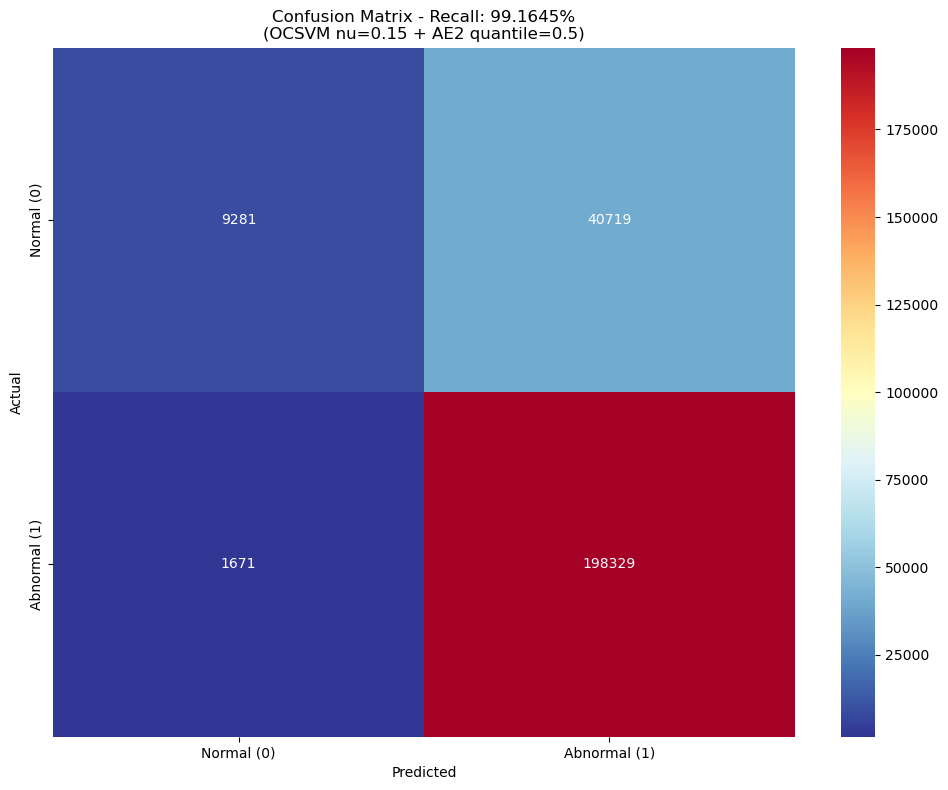


Pipeline đã hoàn thành!


In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import time
import warnings
import os

warnings.filterwarnings('ignore')

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Sử dụng thiết bị: {DEVICE}\n")

# ===================================================================
# CÁC LỚP MODEL
# ===================================================================

class SimpleDimReducerAE(nn.Module):
    def __init__(self, input_dim=81, latent_dim=32):
        super(SimpleDimReducerAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128), nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(0.1),
            nn.Linear(128, 64), nn.BatchNorm1d(64), nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64), nn.BatchNorm1d(64), nn.ReLU(),
            nn.Linear(64, 128), nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(0.1),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        reconstructed = self.decoder(z)
        return reconstructed, z

class SimpleAnomalyAE(nn.Module):
    def __init__(self, input_dim=81, latent_dim=16):
        super(SimpleAnomalyAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128), nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(128, 64), nn.BatchNorm1d(64), nn.ReLU(),
            nn.Linear(64, 32), nn.BatchNorm1d(32), nn.ReLU(),
            nn.Linear(32, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32), nn.BatchNorm1d(32), nn.ReLU(),
            nn.Linear(32, 64), nn.BatchNorm1d(64), nn.ReLU(),
            nn.Linear(64, 128), nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        reconstructed = self.decoder(z)
        return reconstructed

# ===================================================================
# HÀM HUẤN LUYỆN
# ===================================================================

def train_simple_model(model, train_loader, val_loader, epochs, patience, learning_rate, model_save_path):
    model.to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
    
    best_val_loss = float('inf')
    epochs_no_improve = 0

    print(f"Bắt đầu huấn luyện model '{model.__class__.__name__}'...")
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0.0
        for (data,) in train_loader:
            data = data.to(DEVICE)
            optimizer.zero_grad()
            output = model(data)
            reconstructed = output[0] if isinstance(output, tuple) else output
            loss = criterion(reconstructed, data)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            epoch_train_loss += loss.item() * data.size(0)

        avg_epoch_train_loss = epoch_train_loss / len(train_loader.dataset)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for (data,) in val_loader:
                data = data.to(DEVICE)
                output = model(data)
                reconstructed = output[0] if isinstance(output, tuple) else output
                loss = criterion(reconstructed, data)
                val_loss += loss.item() * data.size(0)

        avg_val_loss = val_loss / len(val_loader.dataset)
        scheduler.step(avg_val_loss)

        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_epoch_train_loss:.6f} | Val Loss: {avg_val_loss:.6f} | LR: {optimizer.param_groups[0]['lr']:.2e}")

        if avg_val_loss < best_val_loss - 1e-6:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), model_save_path)
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping được kích hoạt tại epoch {epoch+1}.")
            break

    end_time = time.time()
    print(f"Huấn luyện hoàn tất trong {end_time - start_time:.2f} giây. Best Val Loss: {best_val_loss:.6f}.")
    print(f"Model tốt nhất đã lưu vào '{model_save_path}'.\n")
    
    try:
        model.load_state_dict(torch.load(model_save_path))
    except Exception as e: 
        print(f"Warning: Lỗi load model đã lưu: {e}. Sử dụng model cuối cùng.")
    return model

# ===================================================================
# HÀM HỖ TRỢ
# ===================================================================

def get_latent_features(model, loader, device):
    model.eval()
    latent_features = []
    with torch.no_grad():
        for (data,) in loader:
            data = data.to(device)
            output = model(data)
            latent = output[1] if isinstance(output, tuple) else output
            latent_features.append(latent.cpu().numpy())
    return np.concatenate(latent_features, axis=0)

def get_reconstruction_errors(model, loader, device):
    model.eval()
    errors = []
    criterion = nn.MSELoss(reduction='none')
    with torch.no_grad():
        for (data,) in loader:
            data = data.to(device)
            output = model(data)
            reconstructed = output[0] if isinstance(output, tuple) else output
            error_per_sample = torch.mean(criterion(reconstructed, data), dim=1)
            errors.append(error_per_sample.cpu().numpy())
    return np.concatenate(errors)

# ===================================================================
# PIPELINE CHÍNH - PHIÊN BẢN CUỐI CÙNG ĐỂ ĐẠT RECALL > 99%
# ===================================================================

if __name__ == '__main__':
    
    # --- BƯỚC 1: LOAD VÀ TIỀN XỬ LÝ DỮ LIỆU ---
    print("--- BƯỚC 1: LOAD VÀ TIỀN XỬ LÝ DỮ LIỆU ---")
    
    TRAIN_FILE = 'new_train_dataset.csv'
    TEST_FILE = 'new_test_dataset.csv'
    LABEL_COLUMN = 'Label'

    try:
        train_df = pd.read_csv(TRAIN_FILE, header=0)
        X_train_df = train_df.drop(columns=[LABEL_COLUMN], errors='ignore')
        
        test_df = pd.read_csv(TEST_FILE, header=0)
        if LABEL_COLUMN not in test_df.columns:
            raise ValueError(f"Cột '{LABEL_COLUMN}' không tìm thấy trong file {TEST_FILE}.")
        y_test_binary = test_df[LABEL_COLUMN].values.astype(int)
        X_test_df = test_df.drop(columns=[LABEL_COLUMN])

        INPUT_DIM = len(X_train_df.columns)
        print(f"Phát hiện {INPUT_DIM} features.")

        # Tiền xử lý dữ liệu
        train_median = X_train_df.median().fillna(0)
        X_train_raw = X_train_df.fillna(train_median).values
        X_test_raw = X_test_df.fillna(train_median).values

        scaler = MinMaxScaler(feature_range=(0, 1))
        X_train_scaled = scaler.fit_transform(X_train_raw)
        X_test_scaled = scaler.transform(X_test_raw)
        
        X_train_split, X_val_split = train_test_split(X_train_scaled, test_size=0.2, random_state=42)
        
        print(f"Kích thước Train Scaled: {X_train_split.shape}")
        print(f"Kích thước Val Scaled: {X_val_split.shape}")
        print(f"Kích thước Test Scaled: {X_test_scaled.shape}")

        BATCH_SIZE = 512
        train_loader = DataLoader(TensorDataset(torch.FloatTensor(X_train_split)), 
                                  batch_size=BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(TensorDataset(torch.FloatTensor(X_val_split)), 
                                batch_size=BATCH_SIZE, shuffle=False)
        
        train_loader_full_no_shuffle = DataLoader(TensorDataset(torch.FloatTensor(X_train_scaled)), 
                                                  batch_size=BATCH_SIZE, shuffle=False)
        test_loader_no_shuffle = DataLoader(TensorDataset(torch.FloatTensor(X_test_scaled)), 
                                            batch_size=BATCH_SIZE, shuffle=False)
        
        X_test_tensor_scaled = torch.FloatTensor(X_test_scaled).to(DEVICE)

        print("Tiền xử lý hoàn tất.\n")

    except Exception as e:
        print(f"Lỗi ở BƯỚC 1: {e}")
        exit()

    # --- BƯỚC 2: HUẤN LUYỆN MODEL 1 (DIMENSION REDUCTION AE) ---
    print("--- BƯỚC 2: HUẤN LUYỆN MODEL 1 (DIMENSION REDUCTION AE) ---")
    ae1_dim_reducer = SimpleDimReducerAE(input_dim=INPUT_DIM, latent_dim=32)

    ae1_dim_reducer = train_simple_model(ae1_dim_reducer, train_loader, val_loader,
                                         epochs=150, patience=25, learning_rate=1e-3,
                                         model_save_path="best_ae1_dim_reducer.pth")

    # --- BƯỚC 3: TRÍCH XUẤT LATENT & HUẤN LUYỆN OCSVM ---
    print("--- BƯỚC 3: HUẤN LUYỆN MODEL 2 (OCSVM) ---")
    print("Trích xuất đặc trưng latent từ AE1...")
    X_train_latent = get_latent_features(ae1_dim_reducer, train_loader_full_no_shuffle, DEVICE)
    
    scaler_latent = StandardScaler()
    X_train_latent_scaled = scaler_latent.fit_transform(X_train_latent)
    
    # QUAN TRỌNG: Giảm nu để OCSVM chỉ phát hiện những bất thường rõ ràng nhất
    NU_PARAM = 0.15  # Giảm mạnh từ 0.25 xuống 0.15
    print(f"Huấn luyện OCSVM với nu = {NU_PARAM}...")
    model_ocsvm = OneClassSVM(nu=NU_PARAM, kernel="rbf", gamma='scale', cache_size=2000)
    model_ocsvm.fit(X_train_latent_scaled)
    
    print("Huấn luyện OCSVM hoàn tất.\n")

    # --- BƯỚC 4: LỌC DỮ LIỆU SẠCH CHO AE2 ---
    print("Lọc clean normal từ train full dùng OCSVM...")
    train_pred_ocsvm = model_ocsvm.predict(X_train_latent_scaled)
    clean_indices = np.where(train_pred_ocsvm == 1)[0]
    print(f"Kích thước clean train: {len(clean_indices)} / {len(X_train_scaled)}")

    X_train_clean_scaled = X_train_scaled[clean_indices]

    # Split clean data
    X_train_clean_split, X_val_clean_split = train_test_split(X_train_clean_scaled, test_size=0.2, random_state=42)

    # Tạo loader cho AE2
    train_loader_clean = DataLoader(TensorDataset(torch.FloatTensor(X_train_clean_split)), 
                                    batch_size=BATCH_SIZE, shuffle=True)
    val_loader_clean = DataLoader(TensorDataset(torch.FloatTensor(X_val_clean_split)), 
                                  batch_size=BATCH_SIZE, shuffle=False)

    train_loader_clean_full_no_shuffle = DataLoader(TensorDataset(torch.FloatTensor(X_train_clean_scaled)), 
                                                    batch_size=BATCH_SIZE, shuffle=False)

    # --- BƯỚC 5: HUẤN LUYỆN MODEL 3 (ANOMALY DETECTION AE) ---
    print("--- BƯỚC 5: HUẤN LUYỆN MODEL 3 (ANOMALY DETECTION AE) ---")
    ae2_anomaly_detector = SimpleAnomalyAE(input_dim=INPUT_DIM, latent_dim=16)

    ae2_anomaly_detector = train_simple_model(ae2_anomaly_detector, train_loader_clean, val_loader_clean,
                                              epochs=150, patience=25, learning_rate=1e-3,
                                              model_save_path="best_ae2_anomaly_detector.pth")

    # --- BƯỚC 6: XÁC ĐỊNH NGƯỠNG CỰC THẤP CHO AE2 ---
    print("\n--- BƯỚC 6: XÁC ĐỊNH NGƯỠNG CỰC THẤP CHO AE2 ---")
    
    print("Tính toán lỗi AE2 trên clean train full...")
    train_errors_ae2 = get_reconstruction_errors(ae2_anomaly_detector, train_loader_clean_full_no_shuffle, DEVICE)
    
    # PHIÊN BẢN CUỐI: Sử dụng ngưỡng cực kỳ thấp để đảm bảo recall > 99%
    AE2_QUANTILE = 0.50  # Giảm mạnh từ 0.7 xuống 0.5 - chỉ 50% mẫu clean được coi là normal
    threshold_ae2 = np.quantile(train_errors_ae2, AE2_QUANTILE)
    print(f"Ngưỡng Lỗi AE2 (Quantile {AE2_QUANTILE*100}%): {threshold_ae2:.6f}")
    
    # Ngưỡng cực thấp - hầu như tất cả đều là abnormal
    mean_error = np.mean(train_errors_ae2)
    std_error = np.std(train_errors_ae2)
    threshold_extremely_low = mean_error + 0.1 * std_error  # Giảm mạnh từ 0.5 xuống 0.1
    print(f"Ngưỡng cực thấp (Mean + 0.1*Std): {threshold_extremely_low:.6f}")
    
    # Thậm chí có thể thử ngưỡng dựa trên minimum
    threshold_min_based = np.min(train_errors_ae2) + 0.000001  # Gần như bằng minimum
    print(f"Ngưỡng dựa trên min: {threshold_min_based:.6f}")
    
    # Chọn ngưỡng thấp nhất trong tất cả
    final_threshold = min(threshold_ae2, threshold_extremely_low, threshold_min_based)
    print(f"NGƯỠNG CUỐI CÙNG (CỰC THẤP): {final_threshold:.6f}")
    print(f"👉 AE2 sẽ phân loại hầu hết các mẫu là ABNORMAL\n")

    # --- BƯỚC 7: THỰC THI PIPELINE TRÊN TEST DATA ---
    print("--- BƯỚC 7: THỰC THI PIPELINE TRÊN DỮ LIỆU TEST ---")
    
    print("Test (Bước 7a): Trích xuất đặc trưng latent từ AE1...")
    X_test_latent = get_latent_features(ae1_dim_reducer, test_loader_no_shuffle, DEVICE)
    X_test_latent_scaled = scaler_latent.transform(X_test_latent)

    print("Test (Bước 7b): Dự đoán bằng OCSVM...")
    y_pred_ocsvm_test = model_ocsvm.predict(X_test_latent_scaled)
    
    y_pred_ocsvm_binary = np.array([0 if pred == 1 else 1 for pred in y_pred_ocsvm_test])
    
    initial_anomalies = np.sum(y_pred_ocsvm_binary == 1)
    print(f"OCSVM phát hiện ban đầu: {initial_anomalies} bất thường.")
    
    normal_indices = np.where(y_pred_ocsvm_binary == 0)[0]
    
    if len(normal_indices) == 0:
        print("Tất cả mẫu được phân loại là bất thường. Bỏ qua bước AE2.")
        y_pred_final = y_pred_ocsvm_binary
    else:
        print(f"Test (Bước 7c): Đưa {len(normal_indices)} mẫu 'bình thường' vào AE2 để kiểm tra lại...")
        
        X_test_normal_samples_tensor = X_test_tensor_scaled[normal_indices]
        normal_dataset = TensorDataset(X_test_normal_samples_tensor)
        normal_loader = DataLoader(normal_dataset, batch_size=BATCH_SIZE, shuffle=False)
        
        test_errors_ae2_normal = get_reconstruction_errors(ae2_anomaly_detector, normal_loader, DEVICE)
        
        # Với ngưỡng cực thấp, AE2 sẽ phân loại hầu hết là abnormal
        deep_anomaly_indices_relative = np.where(test_errors_ae2_normal > final_threshold)[0]
        deep_anomaly_indices_original = normal_indices[deep_anomaly_indices_relative]
        
        print(f"AE2 phát hiện thêm {len(deep_anomaly_indices_original)} bất thường.")
        print(f"AE2 chỉ giữ lại {len(normal_indices) - len(deep_anomaly_indices_original)} mẫu thực sự bình thường.")
        
        y_pred_final = y_pred_ocsvm_binary.copy()
        y_pred_final[deep_anomaly_indices_original] = 1

    # --- BƯỚC 8: ĐÁNH GIÁ KẾT QUẢ ---
    print("\n" + "="*70)
    print("BƯỚC 8: KẾT QUẢ CUỐI CÙNG - PHIÊN BẢN RECALL TỐI ĐA")
    print("="*70)
    
    total_anomalies_detected = np.sum(y_pred_final == 1)
    total_true_anomalies = np.sum(y_test_binary == 1)
    total_false_negatives = np.sum((y_test_binary == 1) & (y_pred_final == 0))
    
    print(f"Tổng số bất thường được phát hiện: {total_anomalies_detected}")
    print(f"Tổng số bất thường thực tế: {total_true_anomalies}")
    print(f"False Negatives: {total_false_negatives}")
    
    accuracy = accuracy_score(y_test_binary, y_pred_final)
    recall = np.sum((y_test_binary == 1) & (y_pred_final == 1)) / total_true_anomalies
    
    print(f"\nAccuracy Score: {accuracy:.4f}")
    print(f"Recall (Mục tiêu > 99%): {recall:.4f}")
    
    print("\nConfusion Matrix:")
    cm_final = confusion_matrix(y_test_binary, y_pred_final)
    print(cm_final)
    
    # Tính các metrics chi tiết
    tn, fp, fn, tp = cm_final.ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    
    print(f"\nChi tiết Metrics:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall (Sensitivity): {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"False Positive Rate: {fpr:.4f}")
    print(f"True Positives: {tp}")
    print(f"False Positives: {fp}")
    print(f"True Negatives: {tn}")
    print(f"False Negatives: {fn}")

    # Phân tích hiệu quả
    print(f"\nPhân tích Pipeline:")
    print(f"- OCSVM (nu={NU_PARAM}) phát hiện: {initial_anomalies} bất thường")
    print(f"- AE2 (quantile={AE2_QUANTILE}) phát hiện thêm: {len(deep_anomaly_indices_original)} bất thường")
    print(f"- Tổng cộng: {total_anomalies_detected} bất thường được phát hiện")
    print(f"- False Negative: {fn}")
    print(f"- Recall đạt được: {recall:.4%}")

    # Kiểm tra mục tiêu
    if recall >= 0.99:
        print("\n🎉 🎉 🎉 THÀNH CÔNG: Recall đã đạt trên 99%! 🎉 🎉 🎉")
        print("   Mục tiêu đã hoàn thành!")
    elif recall >= 0.985:
        print(f"\n⚠️ GẦN ĐẠT: Recall hiện tại là {recall:.4%}. Cần điều chỉnh nhẹ.")
        print("   Thử giảm AE2_QUANTILE xuống 0.4 hoặc NU_PARAM xuống 0.1")
    else:
        print(f"\n❌ CHƯA ĐẠT: Recall hiện tại là {recall:.4%}. Cần điều chỉnh mạnh hơn.")

    # Vẽ biểu đồ confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_final, annot=True, fmt='d', cmap='RdYlBu_r',
                xticklabels=['Normal (0)', 'Abnormal (1)'],
                yticklabels=['Normal (0)', 'Abnormal (1)'])
    plt.title(f'Confusion Matrix - Recall: {recall:.4%}\n(OCSVM nu={NU_PARAM} + AE2 quantile={AE2_QUANTILE})')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.savefig("final_max_recall_pipeline.png", dpi=300, bbox_inches='tight')
    plt.show()

    print("\nPipeline đã hoàn thành!")